# Contextual BiLSTM with Auxiliary Input(Metadata) followed by 2 fully connected layers

Improves on “Deep Neural Networks for Bot Detection” paper by Kudugunta et al. which uses a Contextual LSTM (200D GloVE) model. Our goal is to match the following performance metric scores reported on “TwiBot-20 A Comprehensive Twitter Bot Detection Benchmark” paper by Feng et al. for this model. This model's metric scores are as follows:

1. ACC: 0.8235
2. F1: 0.8418
3. MCC: 0.6548


# Imports

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

# Helper Functions

In [2]:
# Function to calculate TP, FP, TN, FN
def calculate_confusion_values(y_true, y_pred):
    """
    Calculate TP, FP, TN, FN for binary classification.
    
    Args:
        y_true (tensor): Ground truth labels.
        y_pred (tensor): Predicted labels.
        
    Returns:
        tuple: (TP, FP, TN, FN)
    """
    TP = ((y_true == 1) & (y_pred == 1)).sum().item()  # True Positive: True labels are 1, Predicted labels are 1
    FP = ((y_true == 0) & (y_pred == 1)).sum().item()  # False Positive: True labels are 0, Predicted labels are 1
    TN = ((y_true == 0) & (y_pred == 0)).sum().item()  # True Negative: True labels are 0, Predicted labels are 0
    FN = ((y_true == 1) & (y_pred == 0)).sum().item()  # False Negative: True labels are 1, Predicted labels are 0
    
    return TP, FP, TN, FN

## Loading Data (Test, Train, Validate)

In [3]:
# User Metadata
train_metadata = torch.load("../Data/Processed_Data/train_metadata_tensor.pth")
test_metadata = torch.load("../Data/Processed_Data/test_metadata_tensor.pth")
validate_metadata = torch.load("../Data/Processed_Data/validate_metadata_tensor.pth")

# Tweets Data
train_tweets = torch.load("../Data/Processed_Data/train_tweet_emb_tensor.pth")
test_tweets = torch.load("../Data/Processed_Data/test_tweet_emb_tensor.pth")
validate_tweets = torch.load("../Data/Processed_Data/validate_tweet_emb_tensor.pth")

# Labels
train_labels = torch.load("../Data/Processed_Data/train_label_tensor.pth")
test_labels = torch.load("../Data/Processed_Data/test_label_tensor.pth")
validate_labels = torch.load("../Data/Processed_Data/validate_label_tensor.pth")

In [4]:
print(train_tweets.shape)
print(test_tweets.shape)
print(validate_tweets.shape)

torch.Size([1398465, 200])
torch.Size([199863, 200])
torch.Size([401540, 200])


In [5]:
# For Reproducability
seed = 42
torch.manual_seed(seed)

In [6]:
# Using only 50% of training for time constraints
num_samples = int(train_tweets.shape[0] * 0.8) // 2

class_0_indices = torch.nonzero(train_labels == 0).squeeze()
class_1_indices = torch.nonzero(train_labels == 1).squeeze()

print(class_0_indices.shape)
print(class_1_indices.shape)

# Shuffle the indices using torch.randperm
shuffled_class_0_indices = class_0_indices[torch.randperm(class_0_indices.size(0))]
shuffled_class_1_indices = class_1_indices[torch.randperm(class_1_indices.size(0))]

# Select an equal number of samples from each class
class_0_sampled_indices = shuffled_class_0_indices[:num_samples]
class_1_sampled_indices = shuffled_class_1_indices[:num_samples]

print(class_0_sampled_indices.shape)
print(class_1_sampled_indices.shape)

# Combine the selected indices for a balanced dataset
balanced_indices = torch.cat((class_0_sampled_indices, class_1_sampled_indices))

torch.Size([641831])
torch.Size([756634])
torch.Size([559386])
torch.Size([559386])


In [7]:
train_tweets = train_tweets[balanced_indices]
train_metadata = train_metadata[balanced_indices]
train_labels = train_labels[balanced_indices]

print(train_tweets.shape)

torch.Size([1118772, 200])


In [8]:
print((test_labels == True).sum() / test_labels.shape[0])
print((test_labels == False).sum() / test_labels.shape[0])

tensor(0.5150)
tensor(0.4850)


In [9]:
print((train_labels == True).sum() / train_labels.shape[0])
print((train_labels == False).sum() / train_labels.shape[0])

tensor(0.5000)
tensor(0.5000)



## Passing tweets through LSTM

In [10]:
# BiLSTM Model
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate = 0.0):
        super(LSTMModel, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False, bidirectional = True, dropout = dropout_rate)
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hidden_size * 2, output_size)
        
        
    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, (hn, cn) = self.lstm(x)
        
        output = self.fc(lstm_out[:, -1, :])
         
        return output

In [11]:
# LSTM Model Parameters

input_size = 200 # Number of features in input data(200 for 200D embeddings)
hidden_size = 50
output_size = 32
number_layers = 1 # Number of LSTM Layers

# Creating LSTM Model
lstm_model = LSTMModel(input_size = input_size, hidden_size = hidden_size, output_size = output_size, 
                      num_layers = number_layers)

In [12]:
train_input_data = train_tweets.unsqueeze(1)
train_input_data = train_input_data.to(torch.float32)

test_input_data = test_tweets.unsqueeze(1)
test_input_data = test_input_data.to(torch.float32)

validate_input_data = validate_tweets.unsqueeze(1)
validate_input_data = validate_input_data.to(torch.float32)

# Getting lstm_output for datasets
train_lstm_output = lstm_model(train_input_data)
train_lstm_output = train_lstm_output.detach()

test_lstm_output = lstm_model(test_input_data)
test_lstm_output = test_lstm_output.detach()

validate_lstm_output = lstm_model(validate_input_data)
validate_lstm_output = validate_lstm_output.detach()

In [13]:
print(train_lstm_output.shape)

torch.Size([1118772, 32])


Save model checkpoint

In [14]:
torch.save(train_lstm_output.state_dict(), "Data/Models/best_BiLSTM_model.pth")

AttributeError: 'Tensor' object has no attribute 'state_dict'

## Concatenating with aux input (user metadata)

In [15]:
x_train = torch.hstack((train_lstm_output, train_metadata)).to(torch.float32)

x_test = torch.hstack((test_lstm_output, test_metadata)).to(torch.float32)

x_validate = torch.hstack((validate_lstm_output, validate_metadata)).to(torch.float32)

In [16]:
y_train = train_labels.view(-1, 1).to(torch.float32)

y_test = test_labels.view(-1, 1).to(torch.float32)

y_validate = validate_labels.view(-1, 1).to(torch.float32)

In [17]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_validate.shape, y_validate.shape)

torch.Size([1118772, 37]) torch.Size([1118772, 1])
torch.Size([199863, 37]) torch.Size([199863, 1])
torch.Size([401540, 37]) torch.Size([401540, 1])


In [18]:
x_train.requires_grad_(False)
y_train.requires_grad_(False)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

## Creating Neural Network

In [19]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)  # Second fully connected layer
        self.out = nn.Linear(hidden_size_2, output_size)
        self.dropout = nn.Dropout(p = 0.2)
        
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))  # Output layer
        
        x = self.out(x)
        return x

In [20]:
# Network Parameters
input_size = 37 #40  # Number of input features (tweet embeddings + metadata)
hidden_size_1 = 128  # Number of hidden units in the first fully connected layer
hidden_size_2 = 64  # Number of hidden units in the first fully connected layer
output_size = 1  # Output size (binary classification: 1 output)
batch_size = 64  # Batch size for training

In [21]:
# Creating dataloader
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_validate, y_validate)
validate_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [22]:
# Initialize mode, loss function, and optimizer
torch.manual_seed(seed)
model = NeuralNetwork(input_size, hidden_size_1, hidden_size_2, output_size)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.0001)  

In [23]:
val_errors = []
epochs = []
train_errors = []
# Training the model
num_epochs = 25  # Number of epochs to train

for epoch in range(num_epochs):
    torch.manual_seed(seed)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Getting training error
        predictions_binary = (outputs > 0).float()
            
        TP, FP, TN, FN = calculate_confusion_values(labels, predictions_binary)
            
        train_correct += (TP + TN) 
        train_total += labels.shape[0]
            
    train_error = 100 - (100 * (train_correct * 1.0 / train_total))
    train_errors.append(train_error)
    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Validation Error
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad(): 
        for inputs, labels in validate_loader:

            predictions = model(inputs)
            predictions_binary = (predictions > 0).float()
            
            TP, FP, TN, FN = calculate_confusion_values(labels, predictions_binary)
            
            correct += (TP + TN) 
            total += labels.shape[0]
            
    val_error = 100 - (100 * (correct * 1.0 / total))
    val_errors.append(val_error)
    epochs.append(epoch)

Epoch [1/25], Loss: 53.1530
Epoch [2/25], Loss: 6.0610
Epoch [3/25], Loss: 0.5923
Epoch [4/25], Loss: 0.5490
Epoch [5/25], Loss: 0.5334
Epoch [6/25], Loss: 0.5292
Epoch [7/25], Loss: 0.5287
Epoch [8/25], Loss: 0.5213
Epoch [9/25], Loss: 0.5108
Epoch [10/25], Loss: 0.5140
Epoch [11/25], Loss: 0.5160
Epoch [12/25], Loss: 0.5167
Epoch [13/25], Loss: 0.5049
Epoch [14/25], Loss: 0.5064
Epoch [15/25], Loss: 0.5030
Epoch [16/25], Loss: 0.4990
Epoch [17/25], Loss: 0.5068
Epoch [18/25], Loss: 0.4984
Epoch [19/25], Loss: 0.4904
Epoch [20/25], Loss: 0.4883
Epoch [21/25], Loss: 0.4869
Epoch [22/25], Loss: 0.4822
Epoch [23/25], Loss: 0.4865
Epoch [24/25], Loss: 0.4862
Epoch [25/25], Loss: 0.4783


Save model checkpoint

In [ ]:
torch.save(model.state_dict(), "Data/Models/best_dense_model.pth")

# Visualizing Training

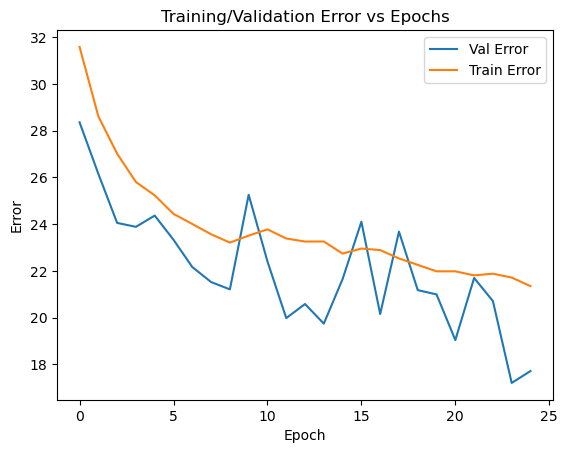

In [25]:
plt.plot(epochs, val_errors, label = "Val Error")
plt.plot(epochs, train_errors, label = "Train Error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.title("Training/Validation Error vs Epochs")

plt.legend()

plt.show()

## Metrics

In [26]:
# Set the model to evaluation mode 
model.eval()

# Make predictions
with torch.no_grad():  # Disable gradient calculation to save memory and computations
    predictions = model(x_test)
    
predictions_binary = (predictions > 0).float()
print("Predictions:", predictions_binary)

Predictions: tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])


In [27]:
TP, FP, TN, FN = calculate_confusion_values(y_test, predictions_binary)

In [28]:
# Accuracy
accuracy = (TP + TN) / (TP + FP + TN + FN) * 100.0
print("Accuracy:", accuracy)

# F1
f1_score = TP / (TP + 0.5 * (FP + FN)) * 100.0
print("F1-Score", f1_score)

# MCC
mcc_score = ((TP * TN) - (FP * FN)) / (((TP +FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5) * 100.0

print("MCC Score:", mcc_score)

Accuracy: 83.3976273747517
F1-Score 85.0319821729834
MCC Score: 67.4668940633239


In [29]:
print(len(predictions.unique()))

192671


In [30]:
print(TP, FP, TN, FN)

94252 24501 72429 8681


## Visualizing the bot/non-bot tweets

In [ ]:
# convert the probabilities for ease of interpretation
probs = torch.sigmoid(predictions).squeeze().numpy()


199863

In [41]:
# pulling the raw data
with open('../Data/test.json', 'r') as file:
        data = json.load(file)
    
# Flatten the JSON using json_normalize
flattened_data = pd.json_normalize(data)

# Convert the flattened data into a Pandas DataFrame
df_raw = pd.DataFrame(flattened_data)

# Explode the tweets column to separate each tweet into its own row
df_explode_tweets = df_raw.explode('tweet').copy()

# add the probabilities to the dataframe
df_explode_tweets['prob'] = probs.tolist()
df_explode_tweets

,ID,tweet,neighbor,domain,label,profile.id,profile.id_str,profile.name,profile.screen_name,profile.location,...,profile.profile_sidebar_border_color,profile.profile_sidebar_fill_color,profile.profile_text_color,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image,neighbor.following,neighbor.follower,prob
0,1188812492010487808,RT @clevelanddotcom: Three Ohio House Republic...,NaN,"[Politics, Sports]",1,1188812492010487808,1188812492010487808,Sharon Israel ⭐️⭐️⭐️,SharonIsrael10,Los Angeles & Colorado,...,C0DEED,DDEEF6,333333,True,True,True,False,NaN,NaN,0.782720
0,1188812492010487808,RT @CaliConserv1: California Governor Gavin Ne...,NaN,"[Politics, Sports]",1,1188812492010487808,1188812492010487808,Sharon Israel ⭐️⭐️⭐️,SharonIsrael10,Los Angeles & Colorado,...,C0DEED,DDEEF6,333333,True,True,True,False,NaN,NaN,0.782216
0,1188812492010487808,RT @NRA: Only after all our guns have been ban...,NaN,"[Politics, Sports]",1,1188812492010487808,1188812492010487808,Sharon Israel ⭐️⭐️⭐️,SharonIsrael10,Los Angeles & Colorado,...,C0DEED,DDEEF6,333333,True,True,True,False,NaN,NaN,0.781862
0,1188812492010487808,@ArtValley818_ CaliRed.\n,NaN,"[Politics, Sports]",1,1188812492010487808,1188812492010487808,Sharon Israel ⭐️⭐️⭐️,SharonIsrael10,Los Angeles & Colorado,...,C0DEED,DDEEF6,333333,True,True,True,False,NaN,NaN,0.783422
0,1188812492010487808,RT @ArtValley818_: I will be looking into star...,NaN,"[Politics, Sports]",1,1188812492010487808,1188812492010487808,Sharon Israel ⭐️⭐️⭐️,SharonIsrael10,Los Angeles & Colorado,...,C0DEED,DDEEF6,333333,True,True,True,False,NaN,NaN,0.782545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,3385331674,"Man, the 70s was a bad-looking decade. Take th...",NaN,[Sports],1,3385331674,3385331674,If You Build It ⚾️,IfYouBuildIt_,New England,...,000000,000000,000000,False,False,False,False,"[365226400, 565659421, 48126072, 7552460517752...","[278098811, 504743392, 471961656, 1435157762, ...",0.817513
1182,3385331674,RT @RobinsonCano: The RC22 DREAM School is sta...,NaN,[Sports],1,3385331674,3385331674,If You Build It ⚾️,IfYouBuildIt_,New England,...,000000,000000,000000,False,False,False,False,"[365226400, 565659421, 48126072, 7552460517752...","[278098811, 504743392, 471961656, 1435157762, ...",0.818167
1182,3385331674,RT @JonHeymanCBS: this is last season for @Don...,NaN,[Sports],1,3385331674,3385331674,If You Build It ⚾️,IfYouBuildIt_,New England,...,000000,000000,000000,False,False,False,False,"[365226400, 565659421, 48126072, 7552460517752...","[278098811, 504743392, 471961656, 1435157762, ...",0.752918
1182,3385331674,RT @whitesox: #SoxSurprise! @BoJackson takes o...,NaN,[Sports],1,3385331674,3385331674,If You Build It ⚾️,IfYouBuildIt_,New England,...,000000,000000,000000,False,False,False,False,"[365226400, 565659421, 48126072, 7552460517752...","[278098811, 504743392, 471961656, 1435157762, ...",0.688322


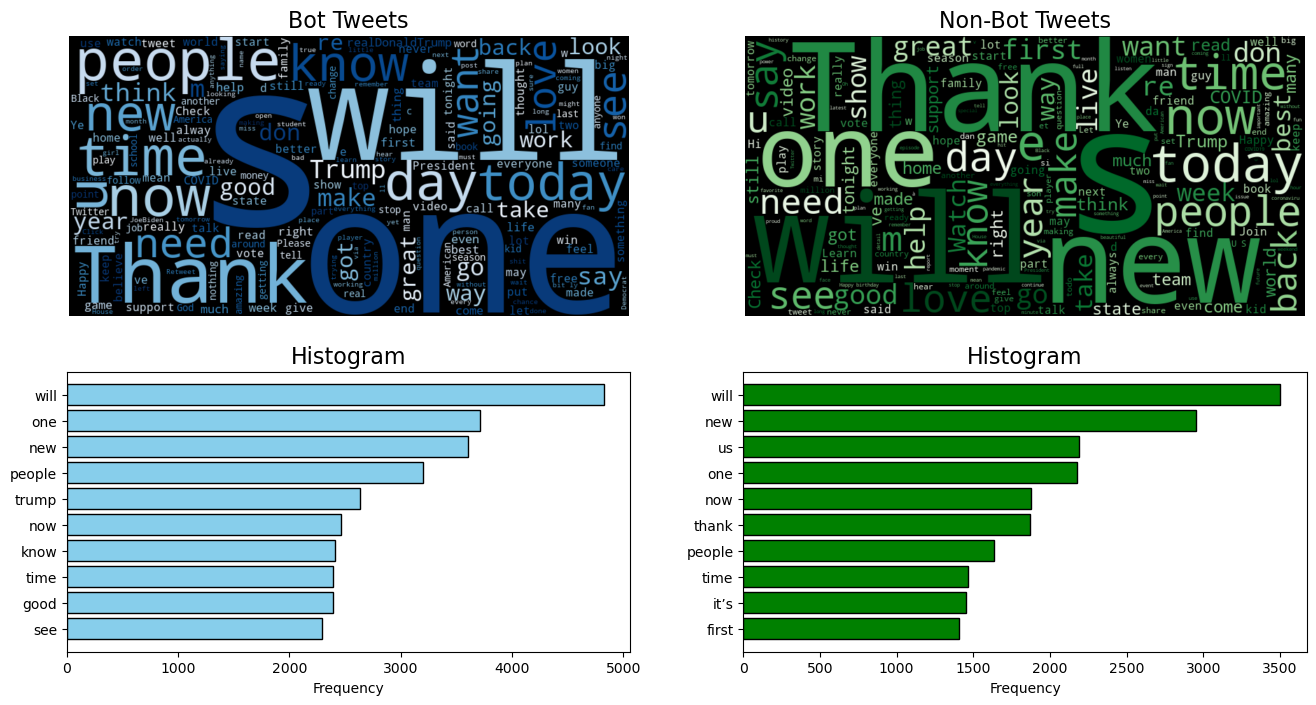

In [49]:
# Combine tweet text into one big string
bot_text = " ".join([str(t) for t in df_explode_tweets[df_explode_tweets['prob'] >= 0.5]['tweet'].tolist() if t is not None])
non_bot_text = " ".join([str(t) for t in df_explode_tweets[df_explode_tweets['prob'] < 0.5]['tweet'].tolist() if t is not None])

# make stopwords
stopwords = set(STOPWORDS)
stopwords.update([
    "rt", "https", "co", "amp", "t.co", "the", "and", "is", "to", "in", "for", "of", "t", 
    "I", "a", "that", "this", "it", "on", "you", "with", "as", "at", "are", "be", "by", "an", 
    "not", "or", "The", "&amp;", "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las",
    "por", "un", "para", "con", "no", "una", "su", "al", "lo", "como", "it's",
    "más", "pero", "sus", "le", "ya", "o", "este", "sí", "porque", "esta", "-", "this", "so", "just",
    "what", "all", "if", "we", "my", "your", "they", "their", "them", "he", "she", "his", "her"
])

# Create word clouds
bot_wc = WordCloud(width=800, height=400, background_color='black', colormap='Blues', stopwords= stopwords).generate(bot_text)
non_bot_wc = WordCloud(width=800, height=400, background_color='black', colormap='Greens', stopwords= stopwords).generate(non_bot_text)


bot_text_split = bot_text.lower().split()
non_bot_text_split = non_bot_text.lower().split()
bot_text_split = [word for word in bot_text_split if word not in stopwords]
non_bot_text_split = [word for word in non_bot_text_split if word not in stopwords]

bot_word_frequencies = Counter(bot_text_split)
non_bot_word_frequencies = Counter(non_bot_text_split)

# Get the most common words for the histogram
bot_most_common_words = bot_word_frequencies.most_common(10)  
non_bot_most_common_words = non_bot_word_frequencies.most_common(10) 

bot_words, bot_frequencies = zip(*bot_most_common_words)
non_bot_words, non_bot_frequencies = zip(*non_bot_most_common_words)

# Plot
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax[0][0].imshow(bot_wc, interpolation='bilinear')
ax[0][0].set_title('Bot Tweets', fontsize=16)
ax[0][0].axis('off')

ax[0][1].imshow(non_bot_wc, interpolation='bilinear')
ax[0][1].set_title('Non-Bot Tweets', fontsize=16)
ax[0][1].axis('off')

ax[1][0].barh(bot_words[::-1], bot_frequencies[::-1], color='skyblue', edgecolor='black')
ax[1][0].set_xlabel('Frequency')
ax[1][0].set_title("Histogram", fontsize=16)

ax[1][1].barh(non_bot_words[::-1], non_bot_frequencies[::-1], color='green', edgecolor='black')
ax[1][1].set_xlabel('Frequency')
ax[1][1].set_title("Histogram", fontsize=16)


plt.show()